# Объединение датасетов Vegetables, fruits360, tasty_fruit

Из разведовательных анализов отдельно каждого датасета известно, что:  
- Датасет **Vegetables** - сбалансирован, имеет по 1400 изображений в каждом из 15 классов.
- Датасет **fruits360** - имеет множество классов. Многие классы являются подклассами для обобщенного класса (к примеру, классы разных типов яблок можно отнести к классу "Яблоко").
- Датасет **tasty_fruit** - имеет около 330 изображений для каждого из 10 классов.

Так как датасет Vegetables уже сбалансирован, то **требуемое количество изображений для классов можно взять 1400**

Принято решение в датасете fruits360 выделить обобщенные классы, из этих классов выбрать те, которые соответствуют требуемому количеству изображений (в них расположены чаще встречаемые фрукты) и классы, которые можно объединить с классами из других датасетов.  
Для классов, в которых будет недостаточно изображений применить oversampling.  
Для классов, превышающих требуемое количество изображений применить undersampling.

In [ ]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from tqdm.auto import tqdm
import shutil
import hashlib

from PIL import Image, ImageEnhance
import random

In [ ]:
FILES_COUNT = 1400
MV_FILES_COUNT = int(FILES_COUNT * 0.4)
RM_FILES_COUNT = FILES_COUNT - MV_FILES_COUNT
TEST_SIZE_PERCENT = 0.2
TEST_COUNT = int(FILES_COUNT * TEST_SIZE_PERCENT)

In [ ]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    DRIVE_DIR = os.path.join("/content/drive", "MyDrive")
except ImportError:
    DRIVE_DIR = os.getcwd()

DATASET_DIR = os.path.join(os.getcwd(), "dataset")
os.makedirs(DATASET_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Распаковка архива
with zipfile.ZipFile(os.path.join(DRIVE_DIR, "dataset.zip"), "r") as zip_ref:
    zip_ref.extractall("./")

# Проверим структуру папок
print(f"{len(os.listdir(DATASET_DIR))} Начальных классов")

166 Начальных классов


## Обобщение классов

Классы из fruits360 имеют число в конце названия, по числу можно отличить от других датасетов

In [ ]:
prev_classes = os.listdir(DATASET_DIR)
classes = []
for cl in prev_classes:
    split_name = cl.split(" ")
    if split_name[0] not in classes:
        classes.append(split_name[0])

print(f"Обобщенных классов {len(classes)}")
print(f"Изначальных классов {len(prev_classes)}")

Обобщенных классов 80
Изначальных классов 166


После обобщения классов из fruits360 получилось 80 классов, было 166

In [ ]:
fruit360_classes = []
prev_sum = 0
for i, cl in tqdm(enumerate(prev_classes)):
    is_fruit360 = re.match(r".*\s\d+", cl) is not None
    if is_fruit360:
        prev_sum = prev_sum + 1
        cl_name = cl.split(" ")[0]
        cl_path = os.path.join(DATASET_DIR, cl)

        new_cl_name = cl_name + "360"
        new_cl_path = os.path.join(DATASET_DIR, new_cl_name)
        if new_cl_name not in fruit360_classes:
            os.makedirs(new_cl_path, exist_ok=True)
            fruit360_classes.append(new_cl_name)

        for img_name in os.listdir(cl_path):
            file_path = os.path.join(DATASET_DIR, cl_path, img_name)
            new_file_path = os.path.join(DATASET_DIR, new_cl_path, str(i) + "_" + img_name)
            shutil.move(file_path, new_file_path)
        if len(os.listdir(cl_path)) > 0:
            print(f"Что-то пошло не так, не все файлы перемещены из папки {cl_path}")
        else:
            os.rmdir(cl_path)

0it [00:00, ?it/s]

In [ ]:
print(f"Было {prev_sum} классов fruits360, стало {len(fruit360_classes)}")

Было 141 классов fruits360, стало 70


Классы из fruits360 удалось сократить примерно в 2 раза при помощи обобщения. Такое обобщение увеличит количество и разнообразие изображений в классах.

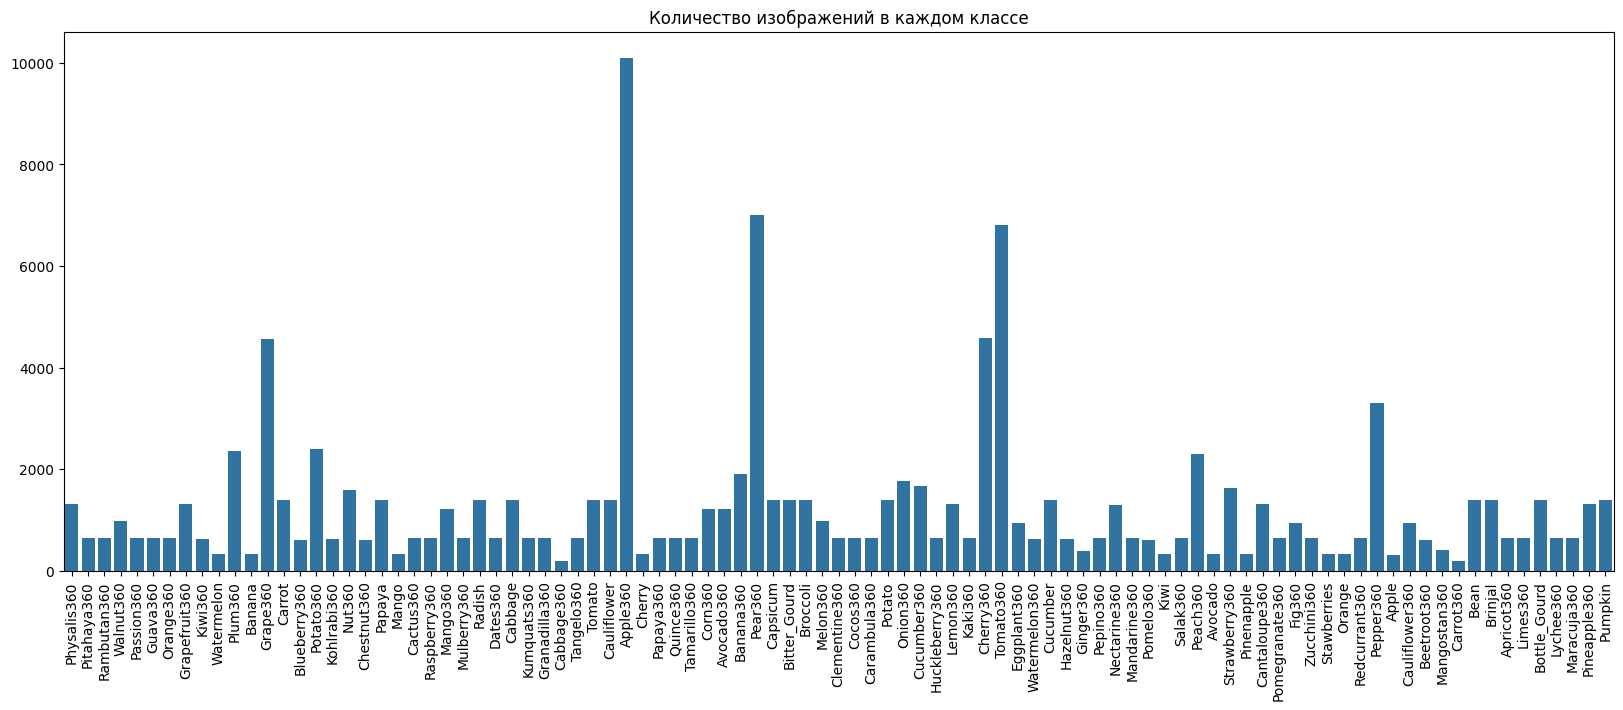

In [ ]:
classes = os.listdir(DATASET_DIR)
class_counts = {cl: len(os.listdir(os.path.join(DATASET_DIR, cl))) for cl in classes}

plt.figure(figsize=(20, 7))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Количество изображений в каждом классе")
plt.show()

Пока что классы из fruits360, пересекающиеся с классами из других датасетов, не объеденены. Датасет получается с большим количеством классов и несбалансированным.  
Можно убрать непопулярные классы с экзотическими фруктами и объединить повторяющиеся классы.

In [ ]:
to_merge = []
to_add = []
others = []
dirs = np.array(os.listdir(DATASET_DIR))
for cl in fruit360_classes:
    if cl[0:-3] in dirs:
        to_merge.append(cl)
    elif len(os.listdir(os.path.join(DATASET_DIR, cl))) > FILES_COUNT:
        to_add.append(cl)
    else:
        others.append(cl)

print(f"Новых классов из fruits360: {len(to_add)}")
print(f"Классов для объединения из fruits360: {len(to_merge)}")
print(f"Классов с малым количеством данных fruits360: {len(others)}")

Новых классов из fruits360: 8
Классов для объединения из fruits360: 15
Классов с малым количеством данных fruits360: 47


Классы с малым количеством данных fruits360 отбросим, т.к. в них представлены фото немногочисленного количества фруктов (~1-3) под разным углом.

In [ ]:
# Сохранение промежуточного результата
INTER_ZIP_PATH = os.path.join(DRIVE_DIR, "inter_dataset")
shutil.make_archive(INTER_ZIP_PATH, "zip", DATASET_DIR)
print(f"Промежуточный этап сохранен в {INTER_ZIP_PATH}")

## Балансировка изображений в классах, удаление лишних классов

Для oversampling используется:
- поворот изображения на определенный градус
- изменение яркости изображения
- изменение контрастности изображения
- отзеркаливание изображения

In [ ]:
def rotate_img(img, angle) -> Image:
    img_rotated = img.rotate(angle, fillcolor=(255, 255, 255))
    return img_rotated


def brightness_img(img, brightness_coeff) -> Image:
    enhancer = ImageEnhance.Brightness(img)
    img_brightened = enhancer.enhance(brightness_coeff)
    return img_brightened.convert("RGB")


def contrasted_img(img, contrast_coeff) -> Image:
    enhancer = ImageEnhance.Contrast(img)
    img_contrasted = enhancer.enhance(contrast_coeff)
    return img_contrasted.convert("RGB")


def transpose_img(img) -> Image:
    img_transposed = img.transpose(Image.FLIP_LEFT_RIGHT)
    return img_transposed

Для undersampling будут выбраны случайные изображения для удаления  
Oversampling использует вышеперечисленные методы

In [ ]:
def save_if_not_exist(file_path, img: Image):
    if os.path.exists(file_path) == False:
        img.save(file_path)
        return True
    return False


def add_new_images(dir_path, filename, prev_count, max_count):
    img = Image.open(os.path.join(dir_path, filename))
    if img.mode != "RGB":
        img = img.convert("RGB")
    br = round(random.uniform(0.5, 1.5), 2)
    while br == 1:
        br = round(random.uniform(0.5, 1.5), 2)
    br_img = brightness_img(img, br)
    if save_if_not_exist(os.path.join(dir_path, f"br{br}_{filename}"), br_img):
        prev_count = prev_count + 1
    if prev_count == max_count:
        return prev_count
    deg = random.randint(1, 359)
    deg_img = rotate_img(img, deg)
    if save_if_not_exist(os.path.join(dir_path, f"deg{deg}_{filename}"), deg_img):
        prev_count = prev_count + 1
    if prev_count == max_count:
        return prev_count
    contr = round(random.uniform(0.5, 1.5), 2)
    while contr == 1:
        contr = round(random.uniform(0.5, 1.5), 2)
    contr_img = contrasted_img(img, contr)
    if save_if_not_exist(os.path.join(dir_path, f"contr{contr}_{filename}"), contr_img):
        prev_count = prev_count + 1
    return prev_count


def oversampling_images(dir_path, max_count):
    files = os.listdir(dir_path)
    random.shuffle(files)
    count = len(files)
    if count > 0:
        while count < max_count:
            for f in files:
                count = add_new_images(dir_path, f, count, max_count)
                if count == max_count:
                    break
                img = Image.open(os.path.join(dir_path, f)).copy()
                if img.mode != "RGB":
                    img = img.convert("RGB")
                tr_img = transpose_img(img)
                if save_if_not_exist(os.path.join(dir_path, f"transp_{f}"), tr_img):
                    count = count + 1
                count = add_new_images(dir_path, f"transp_{f}", count, max_count)
                if count == max_count:
                    break


def undersampling_images(dir_path, max_count):
    files = os.listdir(dir_path)
    count = len(files)
    if count > max_count:
        files_to_remove = random.sample(files, count - max_count)
        for f in files_to_remove:
            rm_path = os.path.join(dir_path, f)
            if os.path.exists(rm_path):
                os.remove(rm_path)
            else:
                print("Файл {rm_path} не найден")

In [ ]:
def create_train_dir(dir_path, train_path):
    os.makedirs(train_path, exist_ok=True)
    shutil.move(dir_path, train_path)


def create_test_dir(dir_path, test_path, test_count):
    files = os.listdir(dir_path)
    test_files = random.sample(files, test_count)

    os.makedirs(test_path, exist_ok=True)

    for f in test_files:
        file_path = os.path.join(dir_path, f)
        shutil.move(file_path, test_path)

In [ ]:
# Добавляет класс с указанным к-вом файлов
def add_class(prev_path, new_path, files_count):
    # Из условия: всегда больше FILES_COUNT, поэтому выполняется undersampling_images
    file_count = len(os.listdir(prev_path))
    undersampling_images(prev_path, files_count)
    os.rename(prev_path, new_path)


# Объединяет классы
def merge_classes(path_to_move, path_to_remove, test_path):

    files_to_move = os.listdir(path_to_remove)
    for f in files_to_move:
        # Переместить файл из первого (удаляемого) во второй (конечный) путь
        shutil.move(os.path.join(path_to_remove, f), os.path.join(path_to_move, f))
    shutil.rmtree(path_to_remove)
    create_test_dir(path_to_move, test_path, TEST_COUNT)
    if len(os.listdir(path_to_move)) > FILES_COUNT - TEST_COUNT:
        undersampling_images(path_to_move, FILES_COUNT - TEST_COUNT)
    else:
        oversampling_images(path_to_move, FILES_COUNT - TEST_COUNT)

In [ ]:
for cl in tqdm(to_add):
    current_dir = os.path.join(DATASET_DIR, cl)
    new_dir = os.path.join(DATASET_DIR, cl[0:-3])
    test_path = os.path.join(DATASET_DIR, "test", cl[0:-3])
    create_test_dir(current_dir, test_path, TEST_COUNT)
    add_class(current_dir, new_dir, FILES_COUNT - TEST_COUNT)

for cl in tqdm(to_merge):
    path_to_move = os.path.join(DATASET_DIR, cl[0:-3])
    path_to_remove = os.path.join(DATASET_DIR, cl)
    test_path = os.path.join(DATASET_DIR, "test", cl[0:-3])
    merge_classes(path_to_move, path_to_remove, test_path)

for cl in tqdm(others):
    shutil.rmtree(os.path.join(DATASET_DIR, cl))

for cl in tqdm(os.listdir(DATASET_DIR)):
    if cl != "test":
        current_dir = os.path.join(DATASET_DIR, cl)
        if os.path.exists(current_dir):
            if not os.path.exists(os.path.join(DATASET_DIR, "test", cl)):
                create_test_dir(current_dir, os.path.join(DATASET_DIR, "test", cl), TEST_COUNT)
            file_count = len(os.listdir(current_dir))
            if file_count < (FILES_COUNT - TEST_COUNT):
                oversampling_images(current_dir, FILES_COUNT - TEST_COUNT)
            create_train_dir(current_dir, os.path.join(DATASET_DIR, "train"))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [ ]:
assert len(os.listdir(TRAIN_DIR)) == len(os.listdir(TEST_DIR))

In [ ]:
classes = os.listdir(TRAIN_DIR)
class_counts = {cl: len(os.listdir(os.path.join(TRAIN_DIR, cl))) for cl in classes}
for cl in class_counts:
    class_counts[cl] = class_counts[cl] + len(os.listdir(os.path.join(TEST_DIR, cl)))

Убедиться, что классы отработали заданные действия

In [ ]:
vegetables = [
    "Bitter_Gourd",
    "Potato",
    "Broccoli",
    "Tomato",
    "Pumpkin",
    "Bottle_Gourd",
    "Carrot",
    "Cucumber",
    "Papaya",
    "Radish",
    "Brinjal",
    "Capsicum",
    "Cabbage",
    "Bean",
    "Cauliflower",
]

for cl in class_counts:
    m = f"{cl}360" in to_merge
    a = f"{cl}360" in to_add
    v = cl in vegetables
    print(f"{cl}:\n  merge: {m}\n  add: {a}\n  vegetables: {v}\n")

print(f"Классов: {len(class_counts)}")

Plum:
  merge: False
  add: True
  vegetables: False

Strawberry:
  merge: False
  add: True
  vegetables: False

Onion:
  merge: False
  add: True
  vegetables: False

Watermelon:
  merge: True
  add: False
  vegetables: False

Banana:
  merge: True
  add: False
  vegetables: False

Carrot:
  merge: True
  add: False
  vegetables: True

Papaya:
  merge: True
  add: False
  vegetables: True

Nut:
  merge: False
  add: True
  vegetables: False

Mango:
  merge: True
  add: False
  vegetables: False

Pepper:
  merge: False
  add: True
  vegetables: False

Radish:
  merge: False
  add: False
  vegetables: True

Cabbage:
  merge: True
  add: False
  vegetables: True

Tomato:
  merge: True
  add: False
  vegetables: True

Pear:
  merge: False
  add: True
  vegetables: False

Cauliflower:
  merge: True
  add: False
  vegetables: True

Grape:
  merge: False
  add: True
  vegetables: False

Cherry:
  merge: True
  add: False
  vegetables: False

Capsicum:
  merge: False
  add: False
  vegetable

In [ ]:
for cl in classes:
    assert len(os.listdir(os.path.join(TRAIN_DIR, cl))) == FILES_COUNT - TEST_COUNT
    assert len(os.listdir(os.path.join(TEST_DIR, cl))) == TEST_COUNT

## Просмотр подготовленного датасета

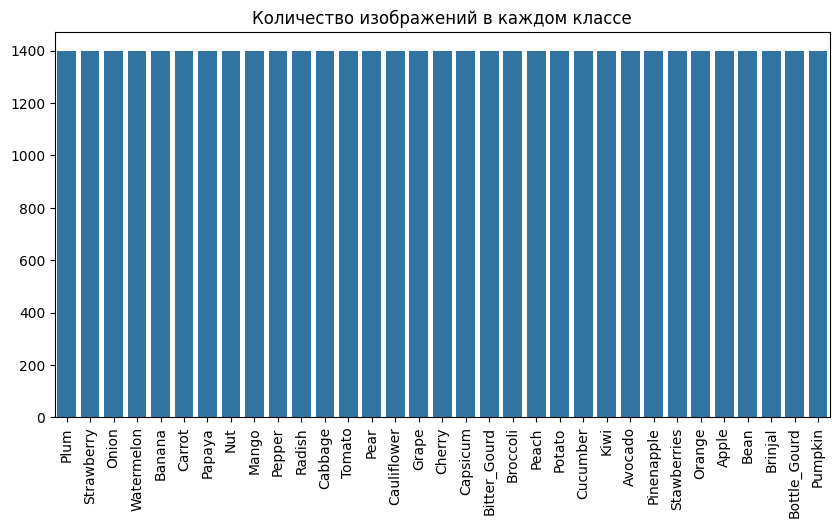

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Количество изображений в каждом классе")
plt.show()

**Получился сбалансированный датасет, содержащий 33 класса по 1400 изображений в каждом.**

In [ ]:
# Функция для отображения нескольких изображений из класса
def show_images(folder_path, cl, num_images=5):
    image_files = random.sample(os.listdir(folder_path), num_images)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(cl)
        plt.axis("off")
    plt.show()


for cl in classes:
    folder_path = os.path.join(TRAIN_DIR, cl)
    show_images(folder_path, cl)

### Проверка изображений на дубликаты

В одной папке (классе) могут содержаться дублирующиеся изображения. Проверим классы на дубликаты, сравнив хеш изображений:

In [ ]:
def get_hash(file_path):
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()


def find_duplicates(folder_path):
    hashes = {}
    duplicates = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        hash = get_hash(file_path)

        if hash in hashes:
            duplicates.append((file_path, hashes[hash]))
        else:
            hashes[hash] = file_path
    return duplicates

In [ ]:
duplicates = dict()
for cls in tqdm(classes):
    path = os.path.join(TRAIN_DIR, cls)
    dup = find_duplicates(path)
    duplicates[cls] = dup

  0%|          | 0/33 [00:00<?, ?it/s]

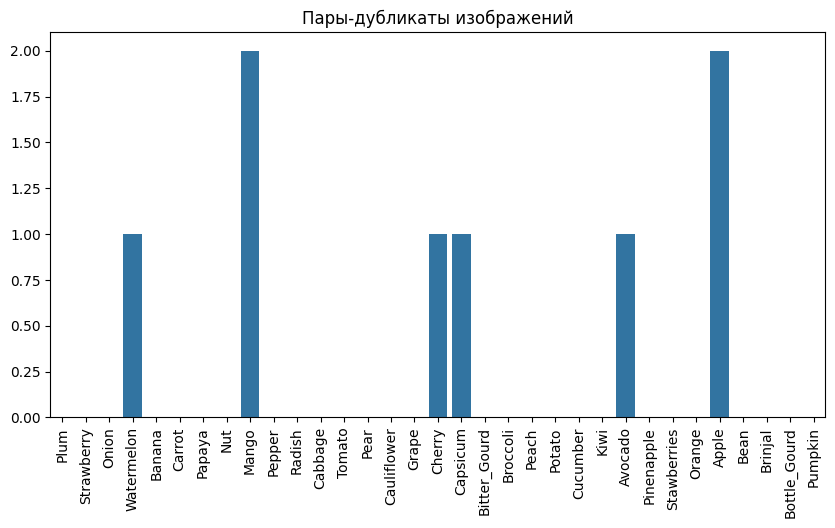

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(duplicates.keys()), y=list([len(values) for values in duplicates.values()]))
plt.xticks(rotation=90)
plt.title("Пары-дубликаты изображений")
plt.show()

**В некоторых классах встречаются дубликаты**

In [ ]:
for cls in duplicates:
    for img_paths in duplicates[cls]:
        dup = img_paths[1]
        img = Image.open(dup)
        if img.mode != "RGB":
            img = img.convert("RGB")

        img = transpose_img(img)

        br = round(random.uniform(0.5, 1.5), 2)
        while br == 1:
            br = round(random.uniform(0.5, 1.5), 2)
        img = brightness_img(img, br)

        deg = random.randint(1, 359)
        img = rotate_img(img, deg)

        contr = round(random.uniform(0.5, 1.5), 2)
        while contr == 1:
            contr = round(random.uniform(0.5, 1.5), 2)
        img = contrasted_img(img, contr)

        img.save(dup)

In [ ]:
duplicates = dict()
for cls in tqdm(classes):
    path = os.path.join(TRAIN_DIR, cls)
    dup = find_duplicates(path)
    duplicates[cls] = dup

  0%|          | 0/33 [00:00<?, ?it/s]

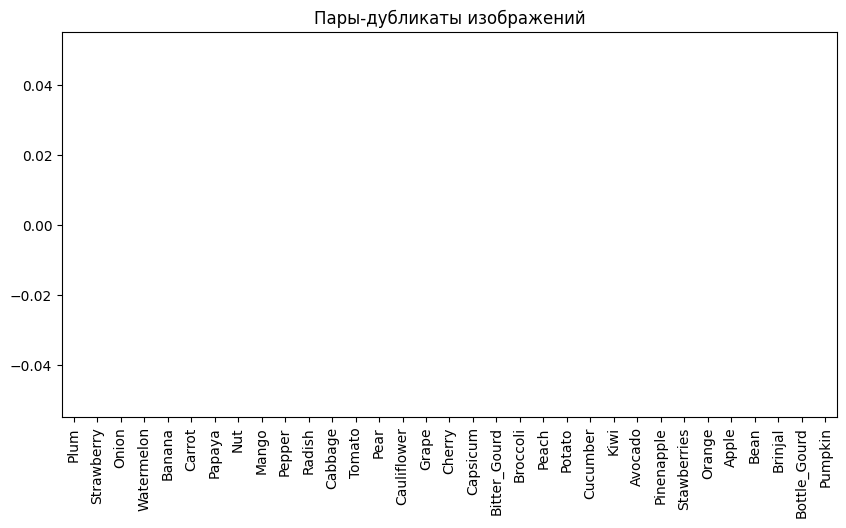

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(duplicates.keys()), y=list([len(values) for values in duplicates.values()]))
plt.xticks(rotation=90)
plt.title("Пары-дубликаты изображений")
plt.show()

### Объединение дублирующихся классов

Дублирующиеся классы Strawberries и Strawberry стоит объединить

In [ ]:
def update_classes(class_to_move, class_to_remove, count):
    # Удалить 40% из Strawberry
    strawberry_files = os.listdir(class_to_move)
    files_to_remove = random.sample(strawberry_files, int(count * 0.6))
    for f in files_to_remove:
        rm_path = os.path.join(class_to_move, f)
        if os.path.exists(rm_path):
            os.remove(rm_path)

    # Переместить 60% из Strawberries в Strawberry
    strawberries_files = os.listdir(class_to_remove)
    files_to_move = random.sample(strawberries_files, int(count * (1 - 0.4)))
    for f in files_to_move:
        mv_path = os.path.join(class_to_remove, f)
        if os.path.exists(mv_path):
            shutil.move(mv_path, class_to_move)

    # Удалить оставшийся дублирующийся класс
    shutil.rmtree(class_to_remove)

In [ ]:
train_class_to_move = os.path.join(TRAIN_DIR, "Strawberry")
train_class_to_remove = os.path.join(TRAIN_DIR, "Stawberries")
update_classes(train_class_to_move, train_class_to_remove, 1120)

test_class_to_move = os.path.join(TEST_DIR, "Strawberry")
test_class_to_remove = os.path.join(TEST_DIR, "Stawberries")
update_classes(test_class_to_move, test_class_to_remove, 280)

In [ ]:
classes = os.listdir(TRAIN_DIR)
class_counts = {cl: len(os.listdir(os.path.join(TRAIN_DIR, cl))) for cl in classes}
for cl in class_counts:
    class_counts[cl] = class_counts[cl] + len(os.listdir(os.path.join(TEST_DIR, cl)))

Проверим классы

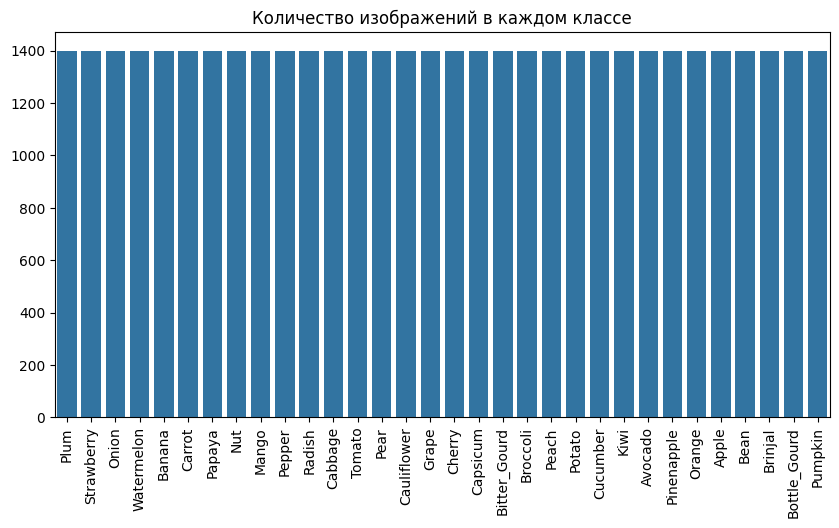

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Количество изображений в каждом классе")
plt.show()

In [ ]:
assert len(classes) == 32

In [ ]:
zip_path = os.path.join(DRIVE_DIR, "dataset_32_classes_splitted")
shutil.make_archive(zip_path, "zip", DATASET_DIR)
print(f"Финальный датасет сохранен в {zip_path}")

Финальный датасет сохранен в /content/drive/MyDrive/dataset_32_classes_splitted
